In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from plots import *
from utils import *

# auto reload modules
%load_ext autoreload
%autoreload 2

# set line width
plt.rcParams['lines.linewidth'] = 1

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Shorting Mature Peaks for Fixed Number of Days

We can try to fix the false positives problem related to the moving average strategy, by dealing with peaks and troughs of the moving average instead of the moving average itself. For instance, if we look at the graph below, there seems to be a clear periodicity. 

The strategy would be to wait until a peak is "mature" enough (passed a certain number of days) and then short for a fixed number of days.

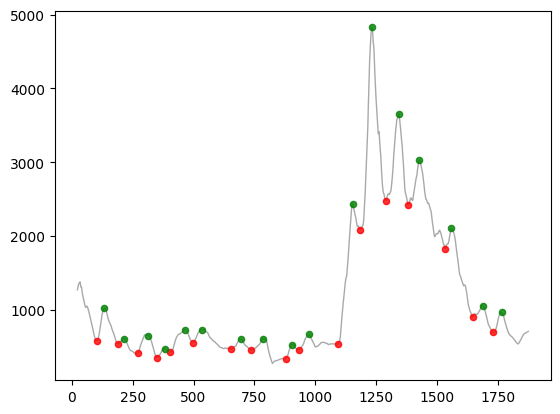

In [9]:
# load data
df = pd.read_csv('mkr_coinmarketcap.csv')
tp = pd.read_csv('mkr_ma24_troughs_and_peaks.csv')
tp = tp['troughs_and_peaks']
df['ma_24'] = df.usd.rolling(24).mean()
df['r'] = df['usd'].pct_change()

plot_peaks_throughs(df.ma_24, tp, s=20, alpha=0.8)

Train & Test Datasets:

In [33]:
train = df.iloc[:1000].copy()
train_tp = tp[tp < train.index[-1]].copy()
test = df.iloc[1000:].copy()

What is median peak age of 24d moving average in a training set?

In [34]:
train_troughs = train_tp[::2].values
train_peaks = train_tp[1::2].values

median_peak_age = int(np.median(train_peaks - train_troughs))
print(f'median peak age: {median_peak_age} days')

median peak age: 38 days


What is the histogram of peak ages?

(array([4., 1., 3., 1., 1.]),
 array([26. , 32.4, 38.8, 45.2, 51.6, 58. ]),
 <BarContainer object of 5 artists>)

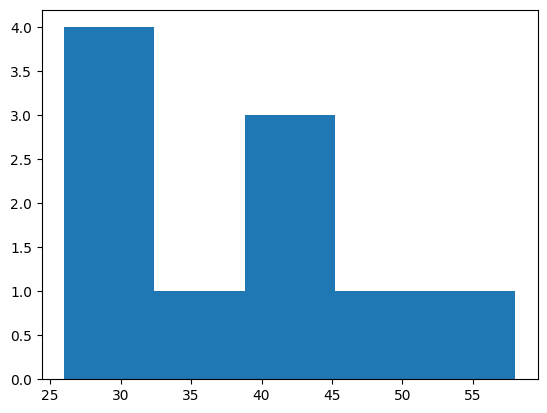

In [45]:
# plot histogram of peak ages
plt.hist(train_peaks - train_troughs, bins=5)

### Implementation

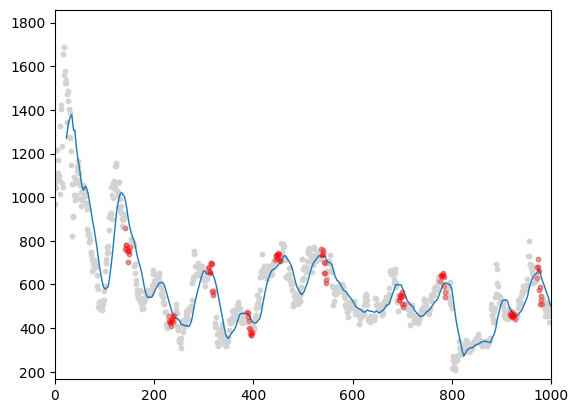

In [35]:
ndays = 10
train['positions'] = 0
train.loc[train_troughs+median_peak_age, 'positions'] = -1
train['positions'] = add_fixed_holding_periods(train.positions, ndays)
# shift positions to avoid lookahead bias
train['positions'] = train.positions.shift(1)

ax = plot_positions(train.usd, train.positions, s=10, scatter_price=True)
ax.plot(train.ma_24)
T1 = 0
T2 = 1000
# set x-limit
ax.set_xlim(T1, T2)
adjust_xy(ax, train.usd, (T1, T2))

<AxesSubplot: title={'center': 'Cumulative Returns'}>

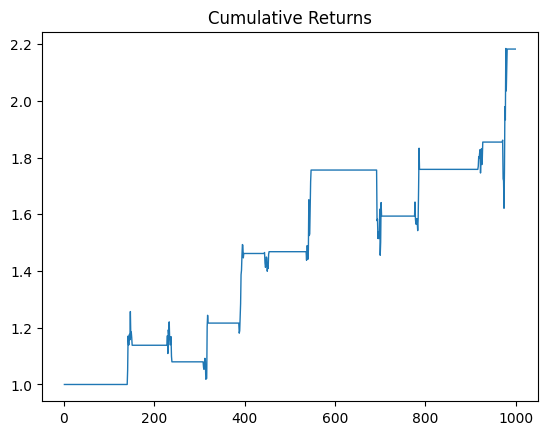

In [38]:
train['strategy_cumr'] = (train.positions * train.r + 1).cumprod()
train.strategy_cumr.plot(title='Cumulative Returns')

#### Debug

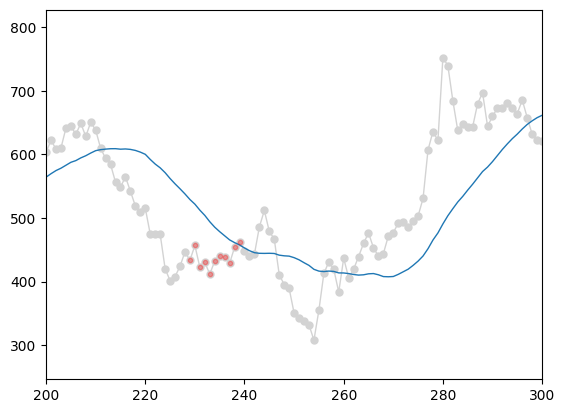

In [47]:
debug(train.usd, train.ma_24, train.positions, 200, 300)

Entry into a large drawdown, with a bounce back followed resulted in a loss.

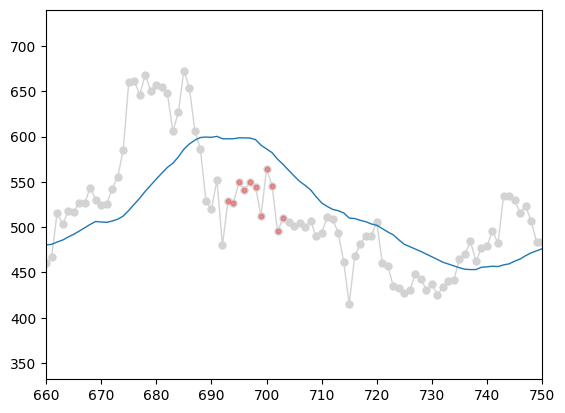

In [50]:
debug(train.usd, train.ma_24, train.positions, 660, 750)

Entry into a large drawdown, with a bounce back followed resulted in a loss.

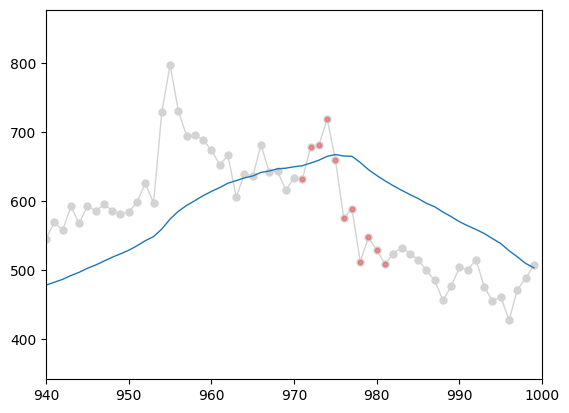

In [52]:
debug(train.usd, train.ma_24, train.positions, 940, 1000)